This script is for handling large light curve data sets obtained from the Catolina survey:

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astroML import time_series as ts
from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from astropy.io import fits
from astropy.table import Table

# Generating Light Curves:

Opening the data set of light curves from Catalina and appending the data into arrays (NOTE: the first set of light curve data obtained from CRTS is called "cat nl set", whereby the information about each source (e.g. RA, DEC, P_orb) in this set is saved in "nl first set with names". Similarly, the second set of light curve data is saved in "cat nl set 2", with the information for these sources being saved in "nl second set with names"):

In [2]:
df1 = pd.read_csv('cat nl set.csv')
#df1 = pd.read_csv('cat nl set 2.csv')
sources = df1.InputID
mjd_pd = df1.MJD
mag_pd = df1.Mag
mag_err_pd = df1.Magerr

df2 = pd.read_csv('nl first set with names.csv')
#df2 = pd.read_csv('nl second with names.csv')
orbs = df2.col4
names = df2.col1
type1 = df2.col5
type2 = df2.col6

Creating a dictionary with the NL source's input ID, Ritter ID and sub-type:

In [3]:
b = set(sources)
b2 = []

dct_sources = {}
for i in b:
    dct_sources[i] = [names[i], type1[i], type2[i]]
    b2.append(i)
    
dct_sources

{3: ['V2731 Oph', 'NL', 'IP'],
 6: ['0928+5004', 'NL', 'UX'],
 8: ['V1062 Tau', 'NL', 'IP'],
 12: ['J0939-3226', 'NL', 'IP'],
 17: ['AC Cnc', 'NL', 'UX'],
 20: ['2347-3144', 'NL', nan],
 21: ['J0644+3344', 'NL', 'SW'],
 22: ['CM Phe', 'NL', nan],
 23: ['EI UMa', 'NL', 'IP'],
 24: ['TW Pic', 'NL', 'VY'],
 25: ['XY Ari', 'NL', 'IP'],
 28: ['TX Col', 'NL', 'IP'],
 29: ['J0518+2941', 'NL', nan],
 30: ['DO Leo', 'NL', nan],
 32: ['V347 Pup', 'NL', 'SW'],
 35: ['TV Col', 'NL', 'IP'],
 38: ['PQ Gem', 'NL', 'IP'],
 41: ['V825 Her', 'NL', nan],
 42: ['V345 Pav', 'NL', 'UX'],
 49: ['HY Leo', 'NL', 'IP'],
 50: ['V1323 Her', 'NL', 'IP'],
 51: ['V418 Gem', 'NL', 'IP'],
 55: ['V436 Car', 'NL', nan],
 58: ['0139+0559', 'NL', 'UX'],
 62: ['V1193 Ori', 'NL', 'UX'],
 65: ['UU Aqr', 'NL', 'UX'],
 66: ['J2152+19', 'NL', 'IP'],
 72: ['J0812+1911', 'NL', 'NS'],
 73: ['J1446+0253', 'NL', 'IP'],
 75: ['LX Ser', 'NL', 'VY'],
 77: ['J1040-4701', 'NL', nan],
 78: ['0642+5049', 'NL', 'UX'],
 79: ['J1031-4626', 'N

Creating dictionaries of the MJD, magnitude and magnitude error data for each source, whereby the key to each source's data in each dictionary is it's corresponding input ID, assigned above: 

In [5]:
dct_mjd = {}
dct_mag = {}
dct_mag_err = {}
for i in b:
    dct_mjd[i] = []
    dct_mag[i] = []
    dct_mag_err[i] = []
    for j in range(len(sources)):
        if i == sources[j]:
            dct_mjd[i].append(mjd_pd[j])
            dct_mag[i].append(mag_pd[j])
            dct_mag_err[i].append(mag_err_pd[j])

Plotting light curve for the first 10 sources from dct_sources:

In [1]:
for i in b2[0:10]:
    plt.figure('Source ID: %s' % i)
    plt.errorbar(dct_mjd[i], dct_mag[i], yerr=dct_mag_err[i], fmt='.k', capsize=1, ecolor='#444444',alpha=0.4)
    plt.gca().invert_yaxis()
    plt.ylabel('Magnitude')
    plt.xlabel('Time (MJD)')
    plt.title('Light curve of %s' % dct_sources[i][0])
#plt.savefig('0642+5049 Light curve.png')

NameError: name 'b2' is not defined

Plotting a histogram of times between successive observations for a specific source in order to gain an idea of it's windowing function:

<IPython.core.display.Javascript object>


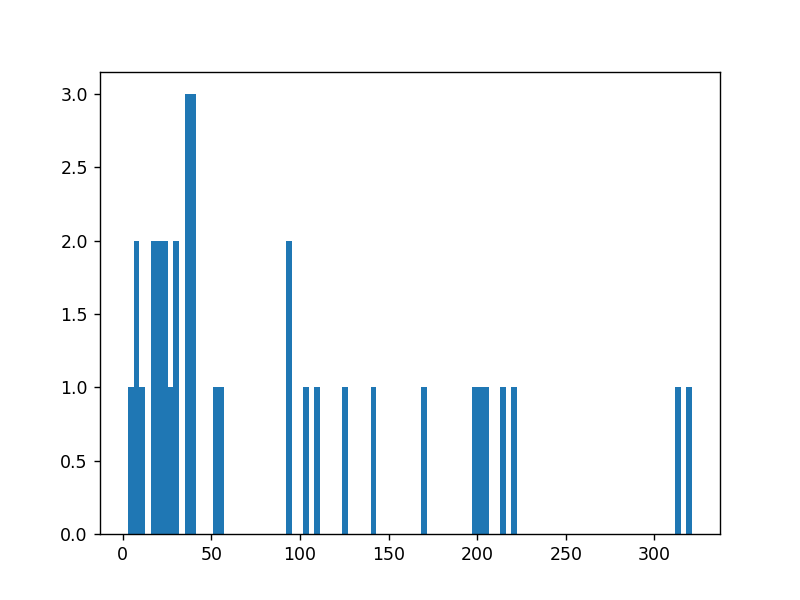

88.1965294286 88.1422446426


In [15]:
from scipy import stats
season = []
mjd_test = sorted(dct_mjd[3])                 # input source ID of specific source to be studied
for i in range(len(mjd_test)):
    if mjd_test[i] != mjd_test[-1]:
        tl = mjd_test[i+1] - mjd_test[i]
        if tl > 2:                            # excluding observation gaps < 2days, which dominate window
            season.append(tl)

hist1, hist_bin1 = np.histogram(season, bins=1000)
plt.figure()
plt.hist(season, bins=100)

m, s = stats.norm.fit(season)
print m, s

Function for folding a particular light curve at a particular frequency:

In [3]:
def fold(mag, mag_err, mjd, f):
    "Phase folds light curve data at specified frequency"
    "Returns lists of phases corresponding to light curve magnitudes and their errors for plotting" 
    phases1 = []
    phases2 = []
    f_2 = []
    f_2_err = []
    

    for i in range(len(mjd)):
        E = (mjd[i] - mjd[0])/(1.0/f)
        phi = E - np.trunc(E)
        phi2 = 1.0 + phi
        if phi < 0:
            phases1.append((1.0 + phi))
            phases2.append((1.0 + phi2))
        else:
            phases1.append(phi)
            phases2.append(phi2)
    

    phases1 = phases1 + phases2
    f_2 = mag + mag
    f_2_err = mag_err + mag_err
    return phases1, f_2, f_2_err

#  Frequency Analysis:

In [16]:
def find_peaks(PS, f, n):
    "Finds the frequencies corresponding to the top power amplitudes in the LS periodogram"
    "Returns top specified n frequencies"
    peaks1 = []
    for i in range(len(PS)):
        if PS[i] != PS[-1]:
            if PS[i] > PS[i-1]:
                if PS[i] > PS[i+1]:
                    peaks1.append(PS[i])
            
    peaks1.sort()
    top1 = []
    for i in range(1, n+1):
        top1.append(peaks1[-i])
    
    top1_f = []
    for j in top1:
        for i in range(len(PS)):
            if PS[i] == j:
                top1_f.append(f[i])
                
    return top1_f

Computing the Lomb-Scargle periodogram for a specific source with the specified frequency grid and appending the subsequent Power Sprectrum data to a dictionary (again where the key is the source's input ID). Plots the Periodogram after being computed:

In [ ]:
dct_PS = {}
dct_fr = {}
for i in b:
    if i == 3:                                                 # Source's input ID
        w_max = (2.0*np.pi)*24.0
        w_min = (2.0*np.pi)/(dct_mjd[i][-1] - dct_mjd[i][0])
        w = np.linspace(w_min, w_max, 600000)
        dct_fr[i] = w/(2.0*np.pi)
        dct_PS[i] = lomb_scargle(dct_mjd[i], dct_mag[i], dct_mag_err[i], w, generalized=True, subtract_mean=True)
        
plt.figure('LS periodogram: 50')
plt.plot(dct_fr['freqr_50'], dct_PS['PS_50'], 'ko', ms=2)
plt.plot(dct_fr['freqr_50'], dct_PS['PS_50'], 'b-', lw=1)
plt.xlabel(r'Frequency (days$^{-1}$)')
plt.ylabel('Power')
plt.title('LS Periodogram of %s' % dct_sources[i][0])

Finding the frequencies which correspond to the top power amplitude peaks in the LS periodogram of a specific source and then subsequently checking if any of them match the orbital frequency from the Ritter catalouge - if they do, they are appended to a dictionary which holds information about each input ID and the frequency which matched the ritter orbital frequency (to a certain tolerance) and it's rank in the top peaks from the periodogram: 

In [4]:
dct_ritt = {}           # dictionary of matched peaks to orbital frequency for each source
dct_peaks = {}          # dictionary of top 5 peaks in periodogram for each source
for i in b:
    if i == 3:
        peaks = find_peaks(dct_PS[i], dct_fr[i], 5)         # 5 top peaks
        ritt_p = orbs[i]
        dct_peaks[i] = peaks
        for j in range(len(peaks)):
            if (ritt_p - ritt_p*0.05) < (1.0/peaks[j]) < (ritt_p + ritt_p*0.05):     # 5% tolerance limit
                if i in dct_ritt:
                    dct_ritt[i].append((j+1, (1.0/peaks[j])))
                else:
                    dct_ritt[i] = [j+1, (1.0/peaks[j])]
        if i not in dct_ritt:
            dct_ritt[i] = 0

NameError: name 'b' is not defined

Other useful functions for frequency analysis:

In [5]:
def find_para(mag, mag_err, mjd, f_orb):
    "Finds best-fit parameters for model sinusoid of frequency f_orb in data mag with errors mag_err and time-stamped at mjd"
    "Returns best-fit parameters and their corresponding variances"
    alpha11 = []
    alpha12 = []
    alpha13 = []
    alpha21 = []
    alpha22 = []
    alpha23 = []
    alpha31 = []
    alpha32 = []
    alpha33 = []
    beta1 = []
    beta2 = []
    beta3 = []
    for i in range(len(mag)):
        k1 = np.sin(2.0*np.pi*f_orb*mjd[i])
        k2 = np.cos(2.0*np.pi*f_orb*mjd[i])
        sigma_i = mag_err[i]
        alpha11.append((k1**2.0/sigma_i**2.0)), alpha12.append((k1*k2/sigma_i**2.0)), alpha13.append((k1/sigma_i**2.0))
        alpha21.append((k1*k2/sigma_i**2.0)), alpha22.append((k2**2.0/sigma_i**2.0)), alpha23.append((k2/sigma_i**2.0))
        alpha31.append((k1/sigma_i**2.0)), alpha32.append((k2/sigma_i**2.0)), alpha33.append((1/sigma_i**2.0))
        beta1.append((mag[i]*k1/sigma_i**2.0))
        beta2.append((mag[i]*k2/sigma_i**2.0))
        beta3.append((mag[i]/sigma_i**2.0))
        
    alpha_mat = np.zeros([3,3])
    alpha_mat[0][0] = np.sum(alpha11)
    alpha_mat[0][1] = np.sum(alpha12)
    alpha_mat[0][2] = np.sum(alpha13)
    alpha_mat[1][0] = np.sum(alpha21)
    alpha_mat[1][1] = np.sum(alpha22)
    alpha_mat[1][2] = np.sum(alpha23)
    alpha_mat[2][0] = np.sum(alpha31)
    alpha_mat[2][1] = np.sum(alpha32)
    alpha_mat[2][2] = np.sum(alpha33)

    beta_mat = np.array([np.sum(beta1), np.sum(beta2), np.sum(beta3)])
    err_mat = np.linalg.inv(alpha_mat)
    para = np.dot(err_mat, beta_mat)
    
    return para, err_mat[0][0], err_mat[1][1], err_mat[2][2]

In [7]:
def chisq(y, yerr, model, N):
    "Calculates reduced chi sqaured for model"
    x_sq = []
    for i in range(N):
        #if y[i] < np.percentile(y, 85.0):                      #condition to remove eclipse data points from calculation 
        term = model[i] - y[i]
        x_sq.append((term/yerr[i])**2.0)
    
    chi_sq = np.sum(x_sq)/N
    return chi_sq

def sigsq(y, model, N):
    "Calculates the uniform variance of the model"
    sig_sq = []
    for i in range(N):
        #if y[i] < np.percentile(y, 85.0):                      #condition to remove eclipse data points from calculation
        term = model[i] - y[i]
        sig_sq.append(term**2.0)
    
    sigma_sq = np.sum(sig_sq)/(N - 3)
    return np.sqrt(sigma_sq)

def Rsq(y, model, N):
    "Calculates the R squared for the model"
    residuals = []
    for i in range(N):
        #if y[i] < np.percentile(y, 85.0):                      #condition to remove eclipse data points from calculation
        residuals.append((model[i] - y[i]))
        
    R_sq = 1 - np.var(residuals)/np.var(y)
    return R_sq